# 04 — Visualisation

Produces five choropleth maps from the scored GeoPackage:
- Pillar 1: Transit Access
- Pillar 2: Demographic Catchment
- Pillar 3: POI Density
- Composite CVI (0–100)
- Market Gap Score

Static PNGs saved to `../outputs/maps/`.  
Interactive Folium map saved to `../outputs/maps/cvi_interactive.html`.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import folium
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

PROCESSED_DIR = Path('../data/processed')
MAPS_DIR = Path('../outputs/maps')
MAPS_DIR.mkdir(parents=True, exist_ok=True)

scored = gpd.read_file(PROCESSED_DIR / 'cvi_scored.gpkg')
scored['GEOID'] = scored['GEOID'].astype(str)

print(f'Tracts loaded: {len(scored)}')
print(f'CRS: {scored.crs}')

Tracts loaded: 205
CRS: EPSG:4326


## 1. Shared map style

Consistent function for all five choropleth maps — same figure size, same annotation style, same basemap approach. Keeps the series visually coherent.

In [2]:
def choropleth_map(gdf, column, title, cmap, filename,
                   scheme='quantiles', k=5,
                   legend_kwds=None, annotate_top=5, annotate_col='cvi_score',
                   diverging=False, vmin=None, vmax=None):
    """
    Consistent choropleth map for all CVI outputs.
    
    diverging=True: uses vmin/vmax centered on 0 (for gap score)
    diverging=False: quantile classification (for pillar scores and CVI)
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    if diverging:
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        gdf.plot(
            column=column, ax=ax,
            cmap=cmap, norm=norm,
            edgecolor='white', linewidth=0.3,
            legend=True,
            legend_kwds={'label': column, 'shrink': 0.5, 'pad': 0.02}
        )
    else:
        if legend_kwds is None:
            legend_kwds = {'fmt': '{:.2f}', 'fontsize': 8}
        gdf.plot(
            column=column, ax=ax,
            cmap=cmap, scheme=scheme, k=k,
            edgecolor='white', linewidth=0.3,
            legend=True, legend_kwds=legend_kwds
        )

    # Annotate top N tracts by the annotation column
    if annotate_top and annotate_col in gdf.columns:
        top = gdf.nlargest(annotate_top, annotate_col)
        for _, row in top.iterrows():
            cx = row.geometry.centroid.x
            cy = row.geometry.centroid.y
            score = row[annotate_col]
            ax.annotate(
                f'{score:.0f}',
                xy=(cx, cy), fontsize=6.5,
                ha='center', va='center',
                color='black',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, ec='none')
            )

    ax.set_title(title, fontsize=14, fontweight='bold', pad=12)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(MAPS_DIR / filename, dpi=200, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')

## 2. Pillar maps

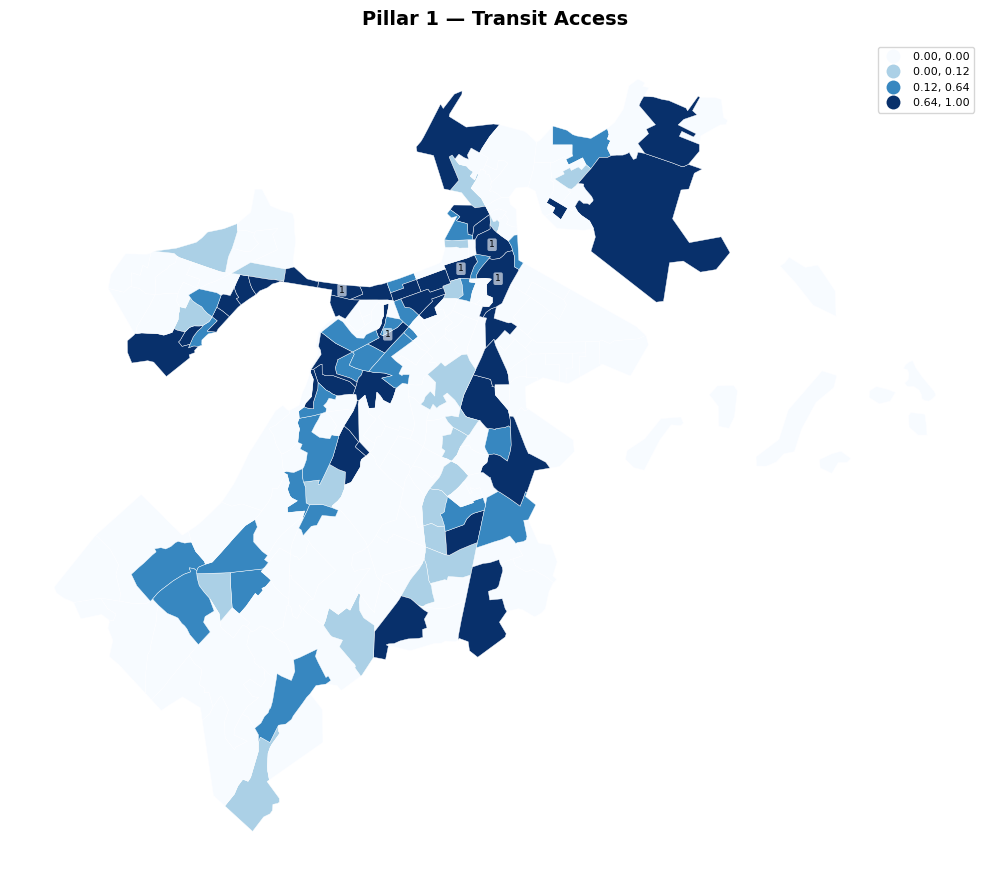

Saved: pillar1_transit.png


In [3]:
# Pillar 1 — Transit Access
choropleth_map(
    gdf=scored,
    column='pillar1_transit',
    title='Pillar 1 — Transit Access',
    cmap='Blues',
    filename='pillar1_transit.png',
    annotate_col='pillar1_transit'
)

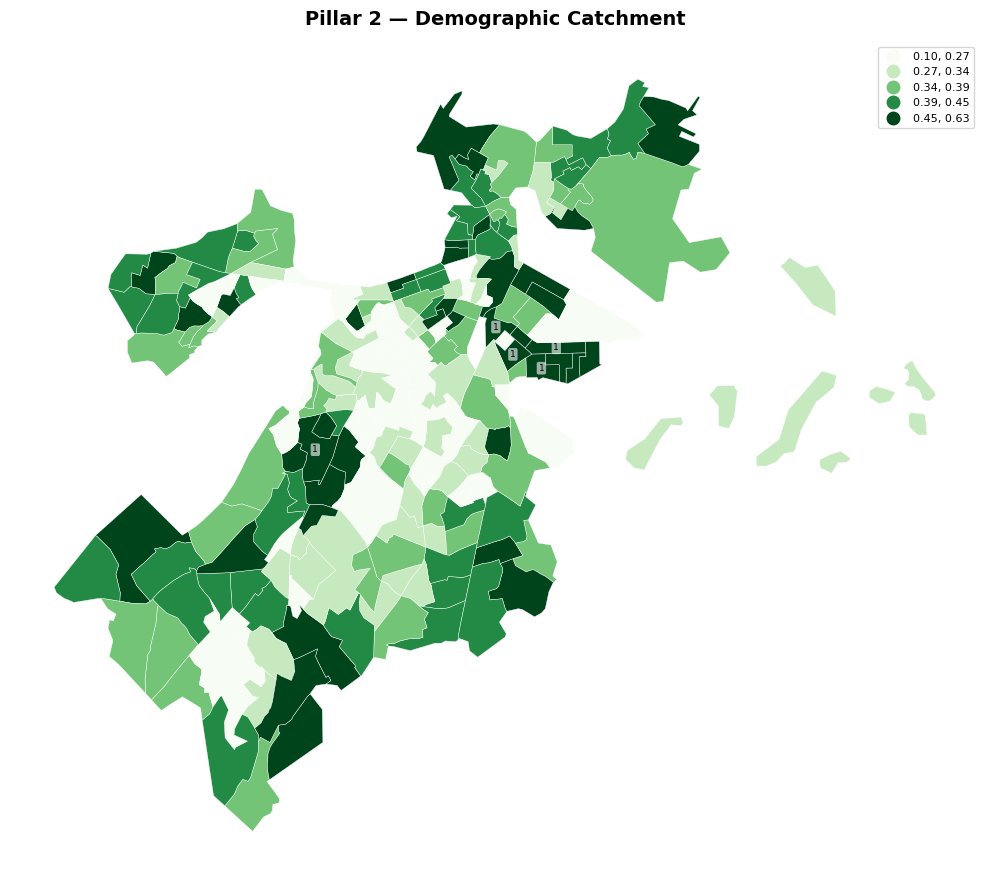

Saved: pillar2_demographics.png


In [4]:
# Pillar 2 — Demographic Catchment
choropleth_map(
    gdf=scored,
    column='pillar2_demographics',
    title='Pillar 2 — Demographic Catchment',
    cmap='Greens',
    filename='pillar2_demographics.png',
    annotate_col='pillar2_demographics'
)

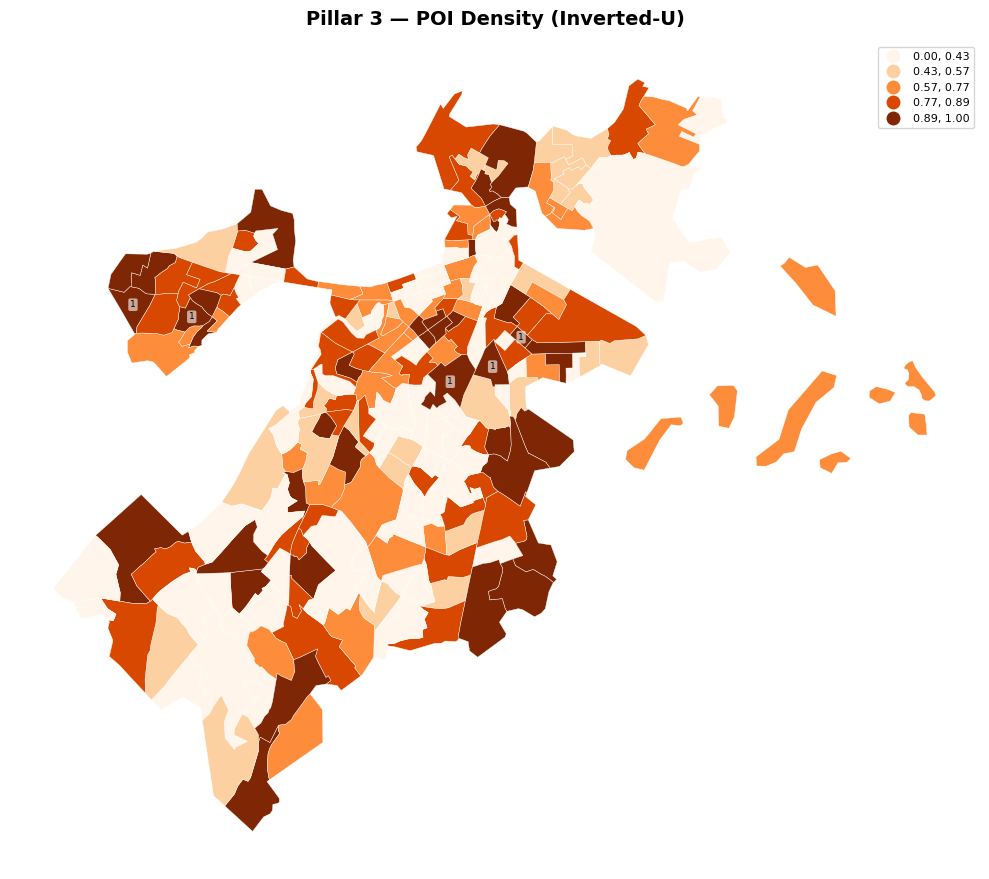

Saved: pillar3_poi_density.png


In [5]:
# Pillar 3 — POI Density (inverted-U scored)
choropleth_map(
    gdf=scored,
    column='pillar3_poi_density',
    title='Pillar 3 — POI Density (Inverted-U)',
    cmap='Oranges',
    filename='pillar3_poi_density.png',
    annotate_col='pillar3_poi_density'
)

## 3. Composite CVI map

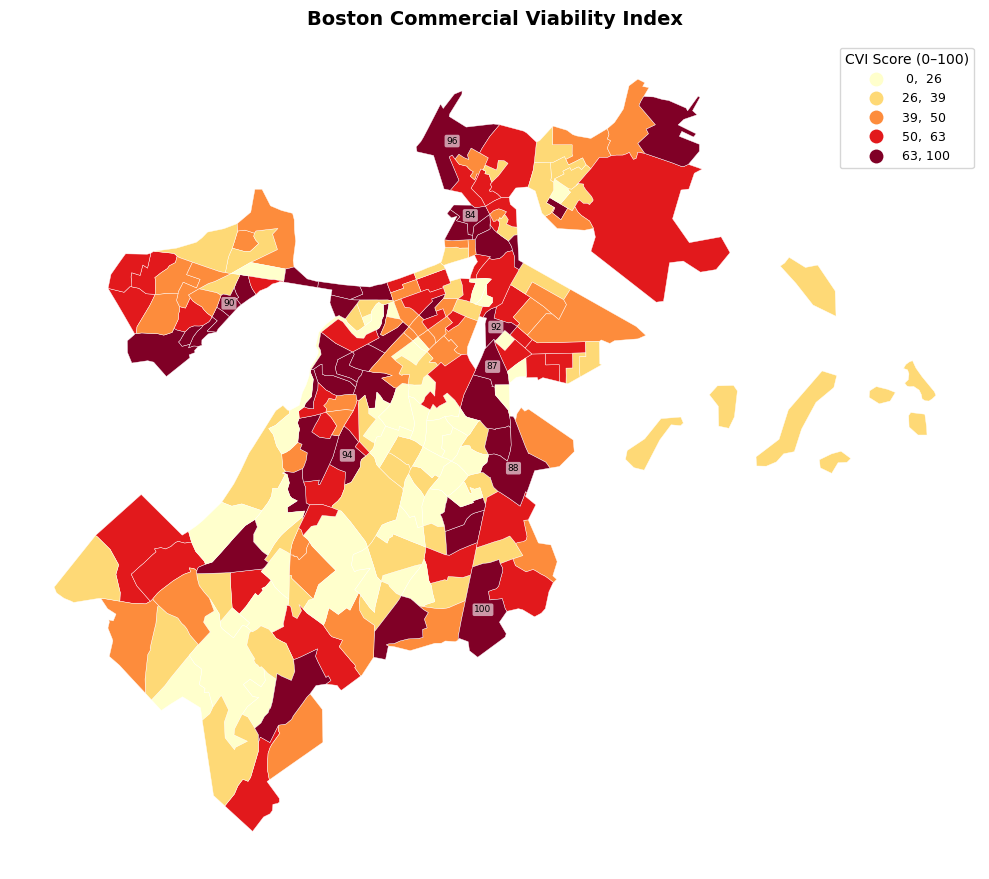

Saved: cvi_composite.png


In [6]:
choropleth_map(
    gdf=scored,
    column='cvi_score',
    title='Boston Commercial Viability Index',
    cmap='YlOrRd',
    filename='cvi_composite.png',
    annotate_top=8,
    annotate_col='cvi_score',
    legend_kwds={'fmt': '{:.0f}', 'fontsize': 9, 'title': 'CVI Score (0–100)'}
)

## 4. Market Gap map

Diverging colour scale centred on 0. Orange/red = underserved (positive gap). Purple/blue = oversaturated (negative gap).

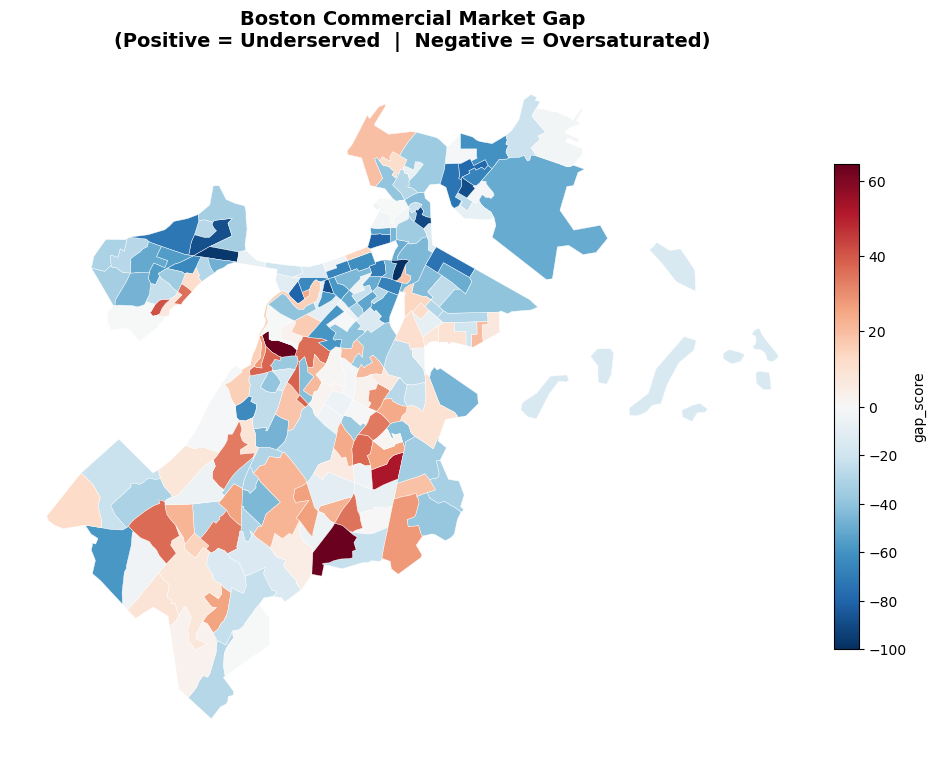

Saved: market_gap.png


In [7]:
gap_min = scored['gap_score'].min()
gap_max = scored['gap_score'].max()

choropleth_map(
    gdf=scored,
    column='gap_score',
    title='Boston Commercial Market Gap\n(Positive = Underserved  |  Negative = Oversaturated)',
    cmap='RdBu_r',
    filename='market_gap.png',
    diverging=True,
    vmin=gap_min,
    vmax=gap_max,
    annotate_top=0  # No annotations on gap map — too cluttered
)

## 5. Interactive Folium map

CVI score + gap score in a single interactive map. Hover tooltips show all key metrics per tract.

In [8]:
# Reproject to WGS84 for Folium
scored_wgs = scored.to_crs(epsg=4326).copy()

# Boston centroid for map initialisation
boston_lat, boston_lon = 42.3601, -71.0589

m = folium.Map(
    location=[boston_lat, boston_lon],
    zoom_start=12,
    tiles='CartoDB positron'
)

# CVI layer
folium.Choropleth(
    geo_data=scored_wgs.__geo_interface__,
    data=scored_wgs[['GEOID', 'cvi_score']],
    columns=['GEOID', 'cvi_score'],
    key_on='feature.properties.GEOID',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Commercial Viability Index (0–100)',
    name='CVI Score',
    show=True
).add_to(m)

# Gap score layer
folium.Choropleth(
    geo_data=scored_wgs.__geo_interface__,
    data=scored_wgs[['GEOID', 'gap_score']],
    columns=['GEOID', 'gap_score'],
    key_on='feature.properties.GEOID',
    fill_color='RdBu_r',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Market Gap Score',
    name='Market Gap',
    show=False
).add_to(m)

# Hover tooltips
tooltip_cols = [
    'GEOID', 'cvi_score', 'gap_score',
    'pillar1_transit', 'pillar2_demographics', 'pillar3_poi_density',
    'total_pois', 'total_stops', 'total_population', 'median_hh_income'
]
tooltip_aliases = [
    'Tract', 'CVI Score', 'Gap Score',
    'Transit', 'Demographics', 'POI Density',
    'Total POIs', 'Total Stops', 'Population', 'Median Income'
]

folium.GeoJson(
    scored_wgs[tooltip_cols + ['geometry']],
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=folium.GeoJsonTooltip(
        fields=tooltip_cols,
        aliases=tooltip_aliases,
        localize=True,
        sticky=False
    ),
    name='Tooltips'
).add_to(m)

folium.LayerControl().add_to(m)

output_path = MAPS_DIR / 'cvi_interactive.html'
m.save(str(output_path))
print(f'Saved: cvi_interactive.html')
print(f'Location: {output_path.resolve()}')
m

Saved: cvi_interactive.html
Location: /Users/administrator/Documents/project 3/outputs/maps/cvi_interactive.html


## 6. Summary — all outputs

In [9]:
expected = [
    'pillar1_transit.png',
    'pillar2_demographics.png',
    'pillar3_poi_density.png',
    'cvi_composite.png',
    'market_gap.png',
    'cvi_interactive.html'
]

print('=== Map Outputs ===')
for f in expected:
    p = MAPS_DIR / f
    size = f'{p.stat().st_size / 1024:.0f} KB' if p.exists() else 'MISSING'
    print(f'  {"OK" if p.exists() else "!!"} {f:<40} {size}')

print(f'\nAll maps saved to: {MAPS_DIR.resolve()}')

=== Map Outputs ===
  OK pillar1_transit.png                      273 KB
  OK pillar2_demographics.png                 360 KB
  OK pillar3_poi_density.png                  341 KB
  OK cvi_composite.png                        355 KB
  OK market_gap.png                           297 KB
  OK cvi_interactive.html                     690 KB

All maps saved to: /Users/administrator/Documents/project 3/outputs/maps
